In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

In [32]:
#load the datasets into a pandas DataFrame
data = pd.read_stata('school_intervention_panel_final.dta', convert_categoricals=False)
follow_up_1_df = data[data['round'] == 0]
follow_up_2_df = data[data['round'] == 1]

categ = ['miss_f_coded', 'female', 'dumm_rp_08_bl', 'dumm_rp_09_bl', 'dumm_rp_14_bl', 
         'dumm_rp_23_bl', 'dumm_rp_24_bl', 'dumm_rp_49_bl', 'business_bl', 'employee_bl', 
         'dumm_rp_50_bl', 'dumm_rp_53B_bl', 'dumm_rp_55_bl', 'dumm_rp_56_bl', 'dumm_rp_59_bl', 
         'dumm_rp_61_bl', 'dumm_rp_64A_bl', 'dumm_rp_65A_bl', 'dumm_rp88__92C_bl', 'dumm_rp88__92D_bl', 
         'dumm_rp88__92AB_bl', 'dumm_rp_93_bl',
         'dumm_rp_94_bl', 'dumm_rp_95_bl', 'dumm_rp_96_bl', 'dumm_negotiates_bl', 'dumm_search_bl', 
         'dumm_rp_08p_bl', 'p_employee_bl', 'p_selfempl_bl', 'p_other_bl', 'dumm_rp_14p_bl', 'dumm_rp_18p_bl',
         'dumm_rp_19p_bl', 'dumm_rp_21p_bl', 'dumm_rp_23p_bl', 'dumm_formal_saving_bl', 'dumm_rp_33p_bl', 
         'dumm_rp_34p_bl', 'dumm_rp_36p_bl', 'dumm_rp_37p_bl']

df_cleaned = follow_up_2_df.dropna(subset=categ)
df_cleaned = df_cleaned.dropna(subset=['treatment', 'dumm_rp88__92C_fup'])
print(df_cleaned.shape)

/tmp/ipykernel_674/1686724179.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  data = pd.read_stata('school_intervention_panel_final.dta', convert_categoricals=False)


(6964, 212)


In [33]:
from sklearn.model_selection import train_test_split
# Define features, treatment, and outcome
X = df_cleaned[categ]  # Covariates
T = df_cleaned['treatment']  # Treatment indicator
Y = df_cleaned['dumm_rp88__92C_fup']  # Outcome

# Combine X and T for S-Learner (treatment is treated as a feature)
X_T = X.copy()
X_T['treatment'] = T

# Split data into train and test sets
train_X, test_X, train_T, test_T, train_Y, test_Y = train_test_split(
    X_T, T, Y, test_size=0.2, random_state=123
)

# Combine features and treatment into training and testing datasets
train_df = train_X.copy()
train_df['treatment'] = train_T
train_df['Y'] = train_Y

test_df = test_X.copy()
test_df['treatment'] = test_T
test_df['Y'] = test_Y

print(train_df[categ])

       miss_f_coded  female  dumm_rp_08_bl  dumm_rp_09_bl  dumm_rp_14_bl  \
34410           0.0     0.0            1.0            1.0            0.0   
12774           0.0     0.0            0.0            1.0            1.0   
65692           0.0     1.0            0.0            1.0            0.0   
46194           0.0     0.0            1.0            1.0            0.0   
64468           0.0     0.0            1.0            0.0            0.0   
...             ...     ...            ...            ...            ...   
37214           0.0     0.0            1.0            1.0            1.0   
29128           0.0     1.0            0.0            0.0            1.0   
9922            0.0     1.0            0.0            0.0            0.0   
24669           0.0     1.0            1.0            0.0            0.0   
25705           0.0     1.0            0.0            0.0            1.0   

       dumm_rp_23_bl  dumm_rp_24_bl  dumm_rp_49_bl  business_bl  employee_bl  \
34410  

In [34]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

T = 'treatment'
y = 'dumm_rp88__92C_fup'

X = categ


debias_m = LGBMRegressor(max_depth=3)

train_pred = train_df.assign(program_res =  train_df[T] -
                          cross_val_predict(debias_m, train_df[X], train_df[T], cv=5)
                          + train_df[T].mean()) # add mu_t for visualization. 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 4456, number of used features: 40
[LightGBM] [Info] Start training from score 0.493716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Notice that I'm calling the $M_t$ model the debias model. That's because the role this model is playing on the Double/Debias ML is one of debiasing the treatment. The residuals $\tilde{T} = T - M_t(X)$ can be viewed as a version of the treatment where all the confounding bias from $X$ has been removed by the model. In other words, $\tilde{T}$ is orthogonal to $X$. Intuitively, $\tilde{T}$ can no longer be explained by $X$, because it already was. 
 
To see that, we can show the same plot we've seen earlier but now replacing price with the price residuals. Remember that, before, weekends had higher prices? Now, that bias is gone. All the weekdays have the same price residual distribution. 

The role of $M_t$ is to debias the treatment, but what about $M_y$? Its role is to remove the variance from $Y$. Hence, I'll call it the denoising model. Intuitively, $M_y$ is creating a version of the outcome where all the variance due to $X$ has been explained away. As a result, it becomes easier to do causal estimation in $\tilde{Y}$. Since it has less noise, the causal relationship becomes easier to see. 

In [35]:
denoise_m = LGBMRegressor(max_depth=3)
y =  'Y'

train_df[y] = train_df[y].astype(bool)
print(train_df[y].dtype)

print(train_df[categ])

test = cross_val_predict(denoise_m, train_df[categ], train_df[y], cv=5)


train_pred = train_pred.assign(credit_res =  train_df[y] -
                               cross_val_predict(denoise_m, train_df[categ], train_df[y], cv=5)
                               + train_df[y].mean())

bool
       miss_f_coded  female  dumm_rp_08_bl  dumm_rp_09_bl  dumm_rp_14_bl  \
34410           0.0     0.0            1.0            1.0            0.0   
12774           0.0     0.0            0.0            1.0            1.0   
65692           0.0     1.0            0.0            1.0            0.0   
46194           0.0     0.0            1.0            1.0            0.0   
64468           0.0     0.0            1.0            0.0            0.0   
...             ...     ...            ...            ...            ...   
37214           0.0     0.0            1.0            1.0            1.0   
29128           0.0     1.0            0.0            0.0            1.0   
9922            0.0     1.0            0.0            0.0            0.0   
24669           0.0     1.0            1.0            0.0            0.0   
25705           0.0     1.0            0.0            0.0            1.0   

       dumm_rp_23_bl  dumm_rp_24_bl  dumm_rp_49_bl  business_bl  employee_bl  \
34

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 
Finally, to estimate that causal relationship, we can run a regression on the residuals.

In [36]:
print(train_pred)
final_model = smf.ols(formula='credit_res ~ program_res', data=train_pred).fit()
final_model.summary().tables[1]

       miss_f_coded  female  dumm_rp_08_bl  dumm_rp_09_bl  dumm_rp_14_bl  \
34410           0.0     0.0            1.0            1.0            0.0   
12774           0.0     0.0            0.0            1.0            1.0   
65692           0.0     1.0            0.0            1.0            0.0   
46194           0.0     0.0            1.0            1.0            0.0   
64468           0.0     0.0            1.0            0.0            0.0   
...             ...     ...            ...            ...            ...   
37214           0.0     0.0            1.0            1.0            1.0   
29128           0.0     1.0            0.0            0.0            1.0   
9922            0.0     1.0            0.0            0.0            0.0   
24669           0.0     1.0            1.0            0.0            0.0   
25705           0.0     1.0            0.0            0.0            1.0   

       dumm_rp_23_bl  dumm_rp_24_bl  dumm_rp_49_bl  business_bl  employee_bl  \
34410  

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2548,0.008,33.348,0.000,0.240,0.270
program_res,0.0066,0.011,0.609,0.542,-0.015,0.028


In [37]:
final_model_cate = smf.ols(formula='credit_res ~ program_res', data=train_pred).fit()

cate_test = test_df.assign(cate=final_model_cate.predict(test_df.assign(program_res=1))
                        - final_model_cate.predict(test_df.assign(program_res=0)))

cate_summary = cate_test['cate'].describe()
print(cate_summary)

count    1.393000e+03
mean     6.596278e-03
std      1.206066e-16
min      6.596278e-03
25%      6.596278e-03
50%      6.596278e-03
75%      6.596278e-03
max      6.596278e-03
Name: cate, dtype: float64


In [38]:
variables = ['dumm_rp_23_bl', 'dumm_rp_59_bl', 'dumm_rp_50_bl', 'dumm_rp_55_bl', 'dumm_rp88__92AB_bl']
results = []

for var in variables:
    formula = f'credit_res ~ {var}'
    model = smf.ols(formula=formula, data=train_pred).fit()
    

    cate_test = test_df.assign(
        cate=model.predict(test_df.assign(**{var: 1})) -
             model.predict(test_df.assign(**{var: 0}))
    )
    conf_int = model.conf_int().loc[var]  # Extract confidence interval for the variable

    cate_summary = cate_test['cate'].describe()
    results.append({
        'Variable': var,
        'Mean': cate_summary['mean'],
        'Std Dev': cate_summary['std'],
        'CI Lower': conf_int[0],  
        'CI Upper': conf_int[1]   
    })


results_df = pd.DataFrame(results)
print(results_df)


             Variable      Mean       Std Dev  CI Lower  CI Upper
0       dumm_rp_23_bl -0.003777  8.763500e-17 -0.025275  0.017722
1       dumm_rp_59_bl -0.005274  1.067238e-16 -0.027774  0.017225
2       dumm_rp_50_bl  0.003463  1.258126e-17 -0.018811  0.025737
3       dumm_rp_55_bl  0.000438  1.008670e-17 -0.023467  0.024344
4  dumm_rp88__92AB_bl  0.000627  0.000000e+00 -0.026658  0.027912


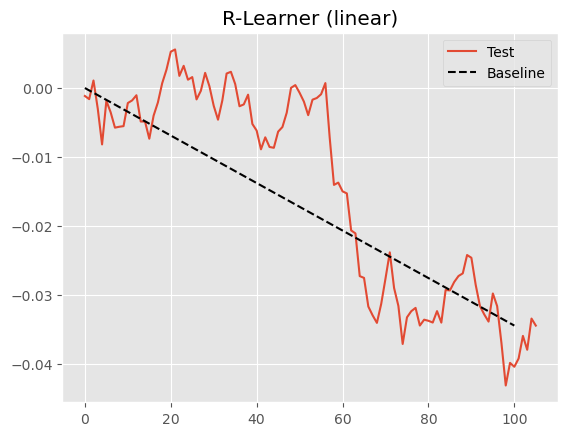

In [39]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test_df, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner (linear)");

In [40]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_df.assign(program_res =  train_df[T] - cross_val_predict(debias_m, train_df[X], train_df[T], cv=5),
                          credit_res =  train_df[y] - cross_val_predict(denoise_m, train_df[X], train_df[y], cv=5))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 4456, number of used features: 40
[LightGBM] [Info] Start training from score 0.493716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [41]:
model_final2 = LGBMRegressor(max_depth=3)
 
# create the weights
w = train_pred["program_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["credit_res"] / train_pred["program_res"])
 
# use a weighted regression ML model to predict the target with the weights.
model_final2.fit(X=train_df[X], y=y_star, sample_weight=w);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 5571, number of used features: 40
[LightGBM] [Info] Start training from score 0.006596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [42]:
print(model_final2)

LGBMRegressor(max_depth=3)


In [43]:
cate_test_non_param = test_df.assign(cate=model_final2.predict(test_df[X]))
cate_summary = cate_test_non_param['cate'].describe()
print(cate_summary)

count    1393.000000
mean        0.006512
std         0.093283
min        -0.406073
25%        -0.054036
50%         0.005034
75%         0.067954
max         0.383725
Name: cate, dtype: float64


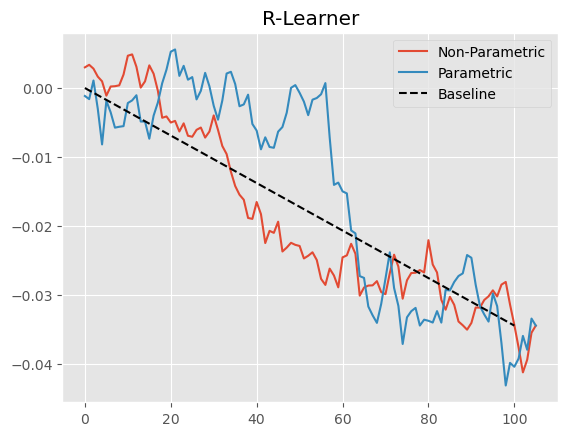

In [44]:
gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, elast(test_df, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");